In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


data = pd.read_csv('/content/diabetes.csv')

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
# Check for missing values
data.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [7]:
print(data['Outcome'].value_counts())
print(data['Outcome'].value_counts(normalize=True) * 100)


Outcome
0    500
1    268
Name: count, dtype: int64
Outcome
0    65.104167
1    34.895833
Name: proportion, dtype: float64


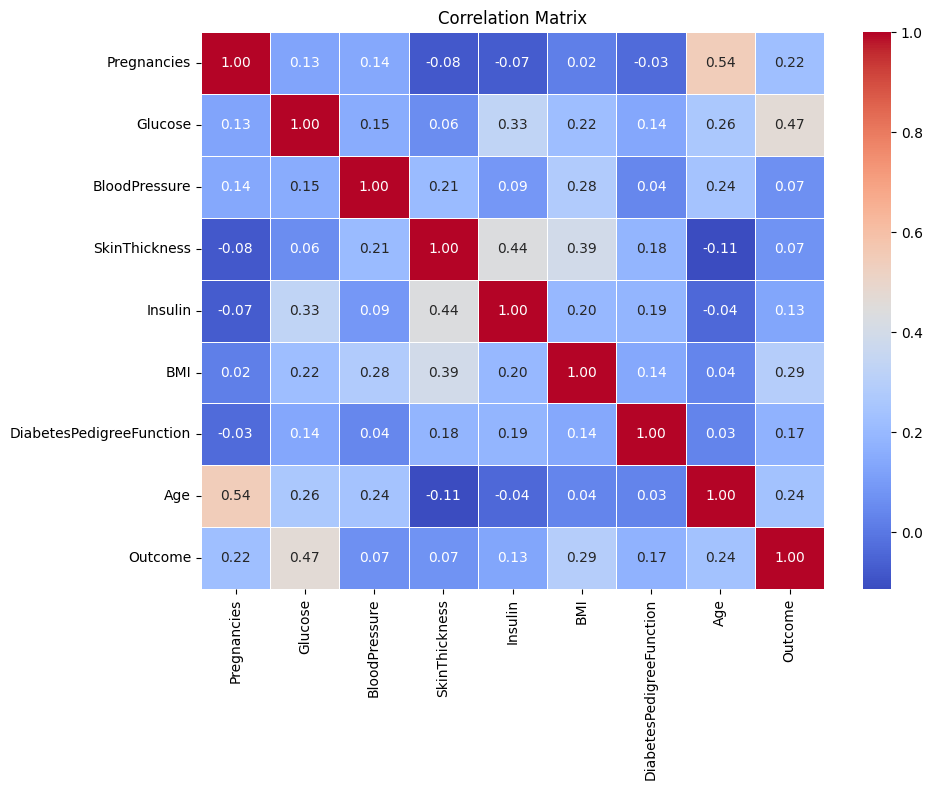

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


In [9]:
X = data.drop('Outcome', axis=1).values  # Features as numpy array
y = data['Outcome'].values

In [10]:
# split the dataset
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Second split: val (15%) and test (15%) from temp (which is 30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train size: {X_train.shape[0]} samples")
print(f"Validation size: {X_val.shape[0]} samples")
print(f"Test size: {X_test.shape[0]} samples")

Train size: 537 samples
Validation size: 115 samples
Test size: 116 samples


In [11]:
# Normalize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [19]:
import numpy as np

# Activation functions and derivatives
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # stability trick
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Cross-entropy loss
def cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    return -np.sum(y_true * np.log(y_pred)) / m

# One-hot encoding
def one_hot_encode(y, num_classes=2):
    return np.eye(num_classes)[y]

# Initialize weights with He initialization
def initialize_parameters(layer_sizes):
    params = {}
    for i in range(1, len(layer_sizes)):
        params['W' + str(i)] = np.random.randn(layer_sizes[i-1], layer_sizes[i]) * np.sqrt(2. / layer_sizes[i-1])
        params['b' + str(i)] = np.zeros((1, layer_sizes[i]))
    return params

In [27]:
def forward_pass(X, params):
    cache = {'A0': X}
    L = len(params) // 2

    for l in range(1, L):
        Z = np.dot(cache['A' + str(l-1)], params['W' + str(l)]) + params['b' + str(l)]
        A = relu(Z)
        cache['Z' + str(l)] = Z
        cache['A' + str(l)] = A

    # Output layer with softmax
    ZL = np.dot(cache['A' + str(L-1)], params['W' + str(L)]) + params['b' + str(L)]
    AL = softmax(ZL)
    cache['Z' + str(L)] = ZL
    cache['A' + str(L)] = AL

    return AL, cache

# Backward pass
def backward_pass(Y_true, params, cache):
    grads = {}
    m = Y_true.shape[0]
    L = len(params) // 2

    dZ = cache['A' + str(L)] - Y_true  # softmax derivative for cross-entropy

    for l in reversed(range(1, L+1)):
        A_prev = cache['A' + str(l-1)]
        grads['dW' + str(l)] = np.dot(A_prev.T, dZ) / m
        grads['db' + str(l)] = np.sum(dZ, axis=0, keepdims=True) / m

        if l > 1:
            dA_prev = np.dot(dZ, params['W' + str(l)].T)
            dZ = dA_prev * relu_derivative(cache['Z' + str(l-1)])

    return grads

# Update parameters
def update_params(params, grads, learning_rate):
    L = len(params) // 2
    for l in range(1, L+1):
        params['W' + str(l)] -= learning_rate * grads['dW' + str(l)]
        params['b' + str(l)] -= learning_rate * grads['db' + str(l)]
    return params

# Predict class labels
def predict(X, params):
    AL, _ = forward_pass(X, params)
    return np.argmax(AL, axis=1)

# Compute accuracy
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

In [38]:
import matplotlib.pyplot as plt

def train(X_train, y_train, X_val, y_val, layer_sizes, epochs=100, learning_rate=0.01):
    params = initialize_parameters(layer_sizes)
    y_train_oh = one_hot_encode(y_train, num_classes=2)
    y_val_oh = one_hot_encode(y_val, num_classes=2)

    losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        AL, cache = forward_pass(X_train, params)
        loss = cross_entropy_loss(y_train_oh, AL)
        losses.append(loss)

        grads = backward_pass(y_train_oh, params, cache)
        params = update_params(params, grads, learning_rate)

        train_preds = predict(X_train, params)
        val_preds = predict(X_val, params)
        train_acc = accuracy(y_train, train_preds)
        val_acc = accuracy(y_val, val_preds)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

    return params, losses, train_accuracies, val_accuracies



Testing architecture: [8, 64, 2]
Epoch 1/200 - Loss: 0.6972 - Train Acc: 0.5456 - Val Acc: 0.6174
Epoch 10/200 - Loss: 0.6735 - Train Acc: 0.6313 - Val Acc: 0.6087
Epoch 20/200 - Loss: 0.6652 - Train Acc: 0.6443 - Val Acc: 0.6261
Epoch 30/200 - Loss: 0.6620 - Train Acc: 0.6480 - Val Acc: 0.6435
Epoch 40/200 - Loss: 0.6601 - Train Acc: 0.6499 - Val Acc: 0.6522
Epoch 50/200 - Loss: 0.6587 - Train Acc: 0.6518 - Val Acc: 0.6522
Epoch 60/200 - Loss: 0.6573 - Train Acc: 0.6536 - Val Acc: 0.6522
Epoch 70/200 - Loss: 0.6560 - Train Acc: 0.6499 - Val Acc: 0.6522
Epoch 80/200 - Loss: 0.6547 - Train Acc: 0.6518 - Val Acc: 0.6522
Epoch 90/200 - Loss: 0.6535 - Train Acc: 0.6499 - Val Acc: 0.6522
Epoch 100/200 - Loss: 0.6522 - Train Acc: 0.6499 - Val Acc: 0.6522
Epoch 110/200 - Loss: 0.6510 - Train Acc: 0.6499 - Val Acc: 0.6522
Epoch 120/200 - Loss: 0.6499 - Train Acc: 0.6499 - Val Acc: 0.6522
Epoch 130/200 - Loss: 0.6487 - Train Acc: 0.6499 - Val Acc: 0.6522
Epoch 140/200 - Loss: 0.6475 - Train Ac

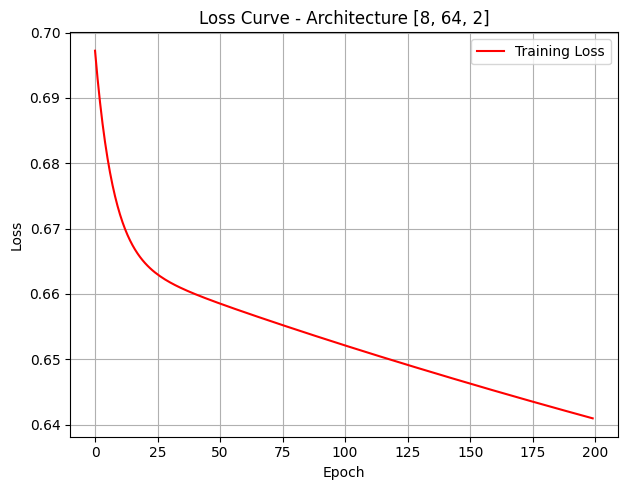


Testing architecture: [8, 128, 64, 2]
Epoch 1/200 - Loss: 1.1016 - Train Acc: 0.3482 - Val Acc: 0.3478
Epoch 10/200 - Loss: 0.6792 - Train Acc: 0.6145 - Val Acc: 0.5826
Epoch 20/200 - Loss: 0.6593 - Train Acc: 0.6555 - Val Acc: 0.6174
Epoch 30/200 - Loss: 0.6527 - Train Acc: 0.6574 - Val Acc: 0.6348
Epoch 40/200 - Loss: 0.6470 - Train Acc: 0.6648 - Val Acc: 0.6348
Epoch 50/200 - Loss: 0.6417 - Train Acc: 0.6629 - Val Acc: 0.6261
Epoch 60/200 - Loss: 0.6370 - Train Acc: 0.6667 - Val Acc: 0.6261
Epoch 70/200 - Loss: 0.6327 - Train Acc: 0.6723 - Val Acc: 0.6261
Epoch 80/200 - Loss: 0.6290 - Train Acc: 0.6667 - Val Acc: 0.6174
Epoch 90/200 - Loss: 0.6257 - Train Acc: 0.6685 - Val Acc: 0.6174
Epoch 100/200 - Loss: 0.6228 - Train Acc: 0.6704 - Val Acc: 0.6174
Epoch 110/200 - Loss: 0.6202 - Train Acc: 0.6704 - Val Acc: 0.6261
Epoch 120/200 - Loss: 0.6178 - Train Acc: 0.6778 - Val Acc: 0.6435
Epoch 130/200 - Loss: 0.6156 - Train Acc: 0.6760 - Val Acc: 0.6348
Epoch 140/200 - Loss: 0.6135 - Tra

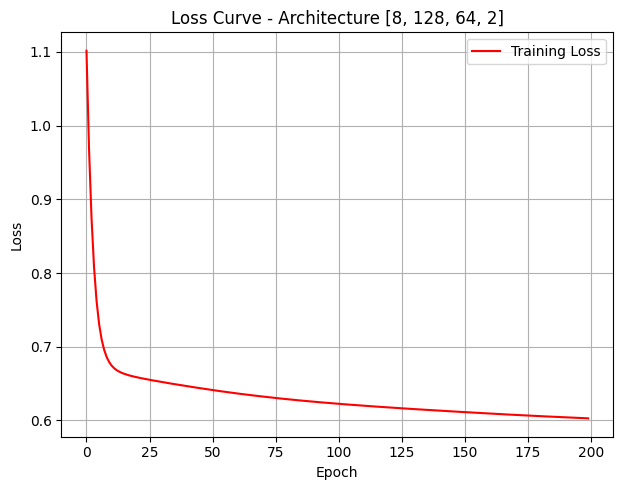


Testing architecture: [8, 256, 128, 64, 2]
Epoch 1/200 - Loss: 0.6849 - Train Acc: 0.6480 - Val Acc: 0.6261
Epoch 10/200 - Loss: 0.6691 - Train Acc: 0.6499 - Val Acc: 0.6609
Epoch 20/200 - Loss: 0.6566 - Train Acc: 0.6462 - Val Acc: 0.6609
Epoch 30/200 - Loss: 0.6465 - Train Acc: 0.6462 - Val Acc: 0.6609
Epoch 40/200 - Loss: 0.6379 - Train Acc: 0.6480 - Val Acc: 0.6609
Epoch 50/200 - Loss: 0.6306 - Train Acc: 0.6536 - Val Acc: 0.6609
Epoch 60/200 - Loss: 0.6243 - Train Acc: 0.6592 - Val Acc: 0.6522
Epoch 70/200 - Loss: 0.6186 - Train Acc: 0.6555 - Val Acc: 0.6435
Epoch 80/200 - Loss: 0.6132 - Train Acc: 0.6648 - Val Acc: 0.6522
Epoch 90/200 - Loss: 0.6083 - Train Acc: 0.6797 - Val Acc: 0.6435
Epoch 100/200 - Loss: 0.6038 - Train Acc: 0.6816 - Val Acc: 0.6348
Epoch 110/200 - Loss: 0.5998 - Train Acc: 0.6797 - Val Acc: 0.6435
Epoch 120/200 - Loss: 0.5959 - Train Acc: 0.6890 - Val Acc: 0.6435
Epoch 130/200 - Loss: 0.5924 - Train Acc: 0.6890 - Val Acc: 0.6609
Epoch 140/200 - Loss: 0.5891 

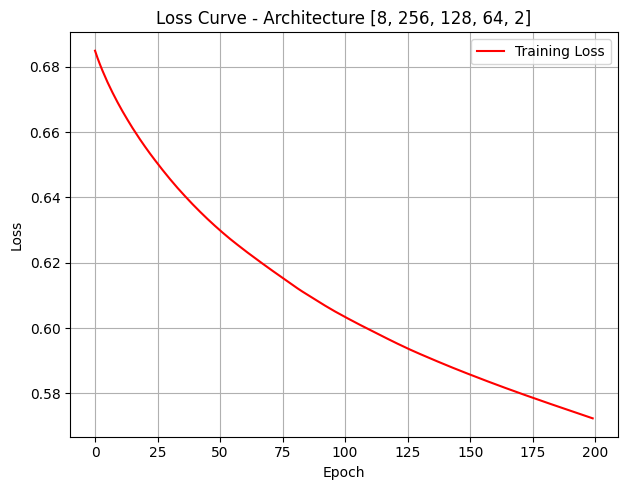


Testing architecture: [8, 512, 256, 128, 64, 2]
Epoch 1/200 - Loss: 0.7373 - Train Acc: 0.5754 - Val Acc: 0.5826
Epoch 10/200 - Loss: 0.6711 - Train Acc: 0.6425 - Val Acc: 0.6348
Epoch 20/200 - Loss: 0.6436 - Train Acc: 0.6629 - Val Acc: 0.6435
Epoch 30/200 - Loss: 0.6269 - Train Acc: 0.6704 - Val Acc: 0.6609
Epoch 40/200 - Loss: 0.6155 - Train Acc: 0.6704 - Val Acc: 0.6870
Epoch 50/200 - Loss: 0.6065 - Train Acc: 0.6834 - Val Acc: 0.6783
Epoch 60/200 - Loss: 0.5990 - Train Acc: 0.6909 - Val Acc: 0.6696
Epoch 70/200 - Loss: 0.5926 - Train Acc: 0.6965 - Val Acc: 0.6696
Epoch 80/200 - Loss: 0.5868 - Train Acc: 0.6946 - Val Acc: 0.6696
Epoch 90/200 - Loss: 0.5817 - Train Acc: 0.7095 - Val Acc: 0.6609
Epoch 100/200 - Loss: 0.5770 - Train Acc: 0.7058 - Val Acc: 0.6783
Epoch 110/200 - Loss: 0.5727 - Train Acc: 0.7114 - Val Acc: 0.6783
Epoch 120/200 - Loss: 0.5688 - Train Acc: 0.7132 - Val Acc: 0.6609
Epoch 130/200 - Loss: 0.5652 - Train Acc: 0.7132 - Val Acc: 0.6696
Epoch 140/200 - Loss: 0.

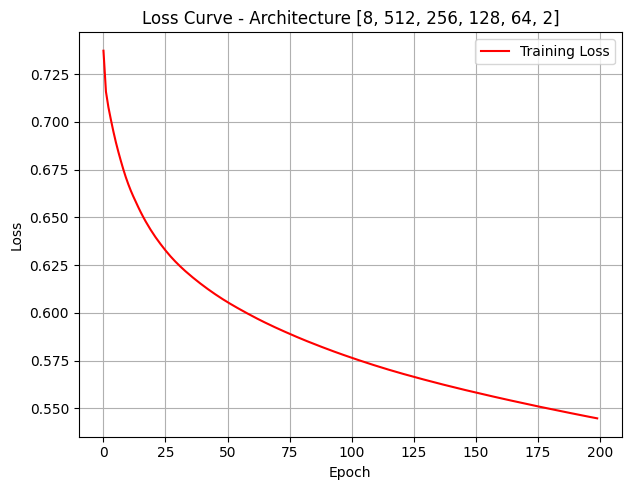

In [45]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

if __name__ == "__main__":
    number_of_features = X_train.shape[1]
    layer_sizes = [number_of_features, 512, 256, 128, 64, 32, 16, 2]
    architectures = [
        [number_of_features, 64, 2],
        [number_of_features, 128, 64, 2],
        [number_of_features, 256, 128, 64, 2],
        [number_of_features, 512, 256, 128, 64, 2]
    ]

    for arch in architectures:
        print(f"\nTesting architecture: {arch}")
        trained_params, losses, train_accs, val_accs = train(
            X_train, y_train, X_val, y_val, arch, epochs=200, learning_rate=0.01
        )
        test_preds = predict(X_test, trained_params)
        acc = accuracy(y_test, test_preds)
        print(f"Accuracy: {acc:.4f}")
        print("Classification Report:")
        print(classification_report(y_test, test_preds))

        # Plot Loss Curve
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(losses, label="Training Loss", color='red')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Loss Curve - Architecture {arch}")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
